In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [3]:
data = load_data(pathlib.Path('../data/bench/weak-scaling-v2/')).sort(
    'framework',
    'num_actors',
)

/tmp/ipykernel_52733/1406852627.py:28: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 4
  axs.legend(


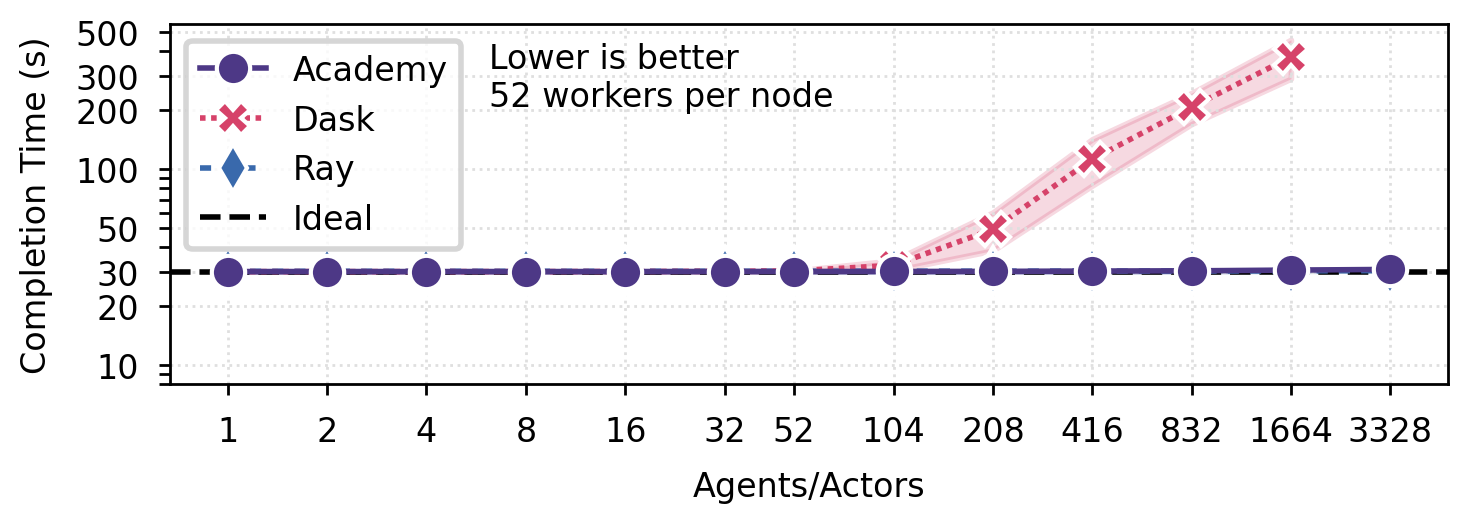

In [4]:
fig, axs = plt.subplots(1, 1)

results = data

xticks = sorted(set(results['num_actors'].to_list()))
yticks = [10, 100, 1000, 10000]
yticks = [10, 20, 30, 50, 100, 200, 300, 500]

dashes = {'ray': (2, 2), 'dask': (1, 1), 'aeris': ()}
markers = {'ray': 'd', 'dask': 'X', 'aeris': 'o'}
palette = {'ray': '#3969AC', 'dask': '#D64269', 'aeris': '#4D3886'}

line_handle = axs.axhline(30, ls='--', color='black', label='ideal')
handle = seaborn.lineplot(
    results,
    x='num_actors',
    y='runtime',
    hue='framework',
    hue_order=['aeris', 'dask', 'ray'][::-1],
    style='framework',
    errorbar='sd',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    loc='upper left',
    handles=handles[::-1] + [line_handle],
    title=None,
    labels=['Academy', 'Dask', 'Ray', 'Ideal'],
    ncols=1,
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Agents/Actors',
    ylabel='Completion Time (s)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
handle.set_yticks(yticks, minor=False)
handle.set_yticklabels([str(y) for y in yticks])
axs.tick_params(axis='x', which='minor', bottom=False)
axs.tick_params(axis='y', which='minor', bottom=False)
axs.set(ylim=[8, 550])

axs.annotate(
    'Lower is better\n52 workers per node',
    xy=(0.25, 0.95),
    xycoords=('axes fraction'),
    ha='left',
    va='top',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.5, 1)
fig.savefig('figures/action-weak-scaling.pdf')